# Similarity Testing for Photos

Given two photographs, we want to have some way of determining the similarity between them.

In [1]:
%matplotlib inline
import os
import random
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import sklearn.manifold
from skimage.io import imread
from skimage.transform import resize as imresize
import tensorflow as tf

/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

## Approach #1: MobileNet Logits
<a id='approach_n_one'></a>

This is well-explained in [here](https://observablehq.com/@nsthorat/how-to-build-a-teachable-machine-with-tensorflow-js).

The idea is to use the result of an image classification net (MobileNet) trained on the ImageNet dataset in order to get an idea of how _similar_ two images are (where similar, in this case, means that the images contain the same kind of things [people, cats, dogs, etc.]).

For viewing purposes, we use some dimensionality reduction algorithm to view the clustered space (such as t-SNE).

### Preparing the Neural Net

Let's start by loading the MobileNet, pre-trained on the ImageNet dataset:

In [3]:
original_model = tf.keras.applications.mobilenet.MobileNet()
original_model.summary()

W1009 17:18:16.401990 140596057966400 deprecation.py:506] From /home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

The last layer is a softmax, which is typical for classification neural nets. However, according to the above mentioned article, we want to use logits instead. So let's change that layer:

In [4]:
inp = original_model.input
out = tf.keras.layers.Activation('linear', name='logits')(original_model.layers[-2].output)
model = tf.keras.Model(inp, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

Let's try the nets out!

[ref](https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299)

In [8]:
def prepare_image(fpath):
    img = tf.keras.preprocessing.image.load_img(fpath, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

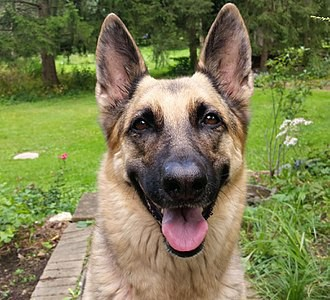

In [6]:
Image(filename="/home/daniel/Desktop/test.jpeg")

In [7]:
preprocessed_image = prepare_image("/home/daniel/Desktop/test.jpeg");

In [8]:
predictions = original_model.predict(preprocessed_image)

array([[1.19461163e-09, 2.84506115e-13, 2.49886414e-11, 4.88193964e-11,
        1.01400301e-12, 2.16586835e-11, 1.63288382e-13, 2.14552291e-12,
        2.95246293e-11, 1.03407148e-12, 8.80158143e-13, 6.58240866e-12,
        1.66328756e-12, 1.61566114e-14, 1.07858512e-13, 3.47058493e-12,
        4.51149014e-12, 1.24923197e-10, 2.46218692e-12, 2.32476234e-12,
        2.68197292e-12, 1.45627416e-11, 9.46774041e-15, 1.61779149e-11,
        2.10289442e-11, 4.51118240e-11, 1.01689325e-11, 5.02934879e-13,
        1.64217754e-11, 3.60708073e-13, 2.33906969e-13, 4.90462824e-15,
        1.23760431e-13, 2.07976802e-10, 3.22387191e-12, 5.18240555e-11,
        1.37026779e-11, 5.73876060e-12, 1.06748464e-12, 3.33736142e-12,
        9.28303333e-13, 9.28834700e-13, 4.01443744e-13, 1.50920400e-12,
        6.75273314e-13, 1.62584113e-10, 2.79064478e-13, 2.50982169e-11,
        3.61054990e-13, 6.44720009e-14, 7.66513724e-14, 5.98883221e-10,
        1.81784969e-11, 1.93016974e-11, 4.68875876e-11, 1.373750

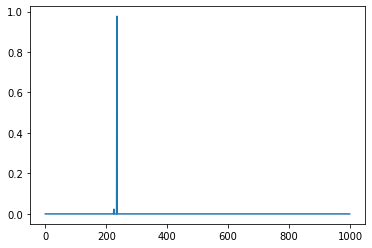

In [9]:
plt.plot(range(predictions.shape[1]), list(predictions[0]));

In [10]:
predictions = model.predict(preprocessed_image)

array([[ 3.74853802e+00, -4.59403944e+00, -1.18618369e-01,
         5.51087976e-01, -3.32313395e+00, -2.61633158e-01,
        -5.14927721e+00, -2.57365656e+00,  4.81849909e-02,
        -3.30353546e+00, -3.46469307e+00, -1.45263791e+00,
        -2.82824397e+00, -7.46246433e+00, -5.56397390e+00,
        -2.09271693e+00, -1.83041191e+00,  1.49065888e+00,
        -2.43598914e+00, -2.49342251e+00, -2.35048723e+00,
        -6.58572614e-01, -7.99690533e+00, -5.53393126e-01,
        -2.91139573e-01,  4.72105533e-01, -1.01770258e+00,
        -4.02433443e+00, -5.38430333e-01, -4.35672665e+00,
        -4.78987074e+00, -8.65461445e+00, -5.42644644e+00,
         2.00038624e+00, -2.16645575e+00,  6.10815108e-01,
        -7.19448388e-01, -1.58979511e+00, -3.27173448e+00,
        -2.13185954e+00, -3.41143656e+00, -3.41086411e+00,
        -4.24972677e+00, -2.92545748e+00, -3.72967720e+00,
         1.75415564e+00, -4.61335278e+00, -1.14242733e-01,
        -4.35576344e+00, -6.07856369e+00, -5.90552807e+0

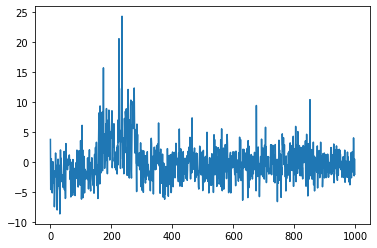

In [11]:
plt.plot(range(predictions.shape[1]), list(predictions[0]));

### Loading the Images

We reuse the function `prepare_image` (defined in the previous section) in order to load a bunch of images in a given directory.

In [17]:
def load_images(directory):
    output = []
    for fname in os.listdir(directory):
        output.append(prepare_image(os.path.join(directory, fname)))
    return output

In [13]:
images = load_images("/media/daniel/Datasets/ims_julia/medeiros_imgs/");

### Running the Images Through the Neural Net

In [14]:
neural_net_outputs = list(map(lambda x: np.squeeze(model.predict(x)), random.sample(images, 100)));

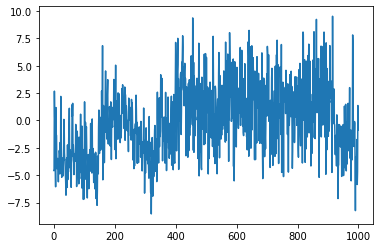

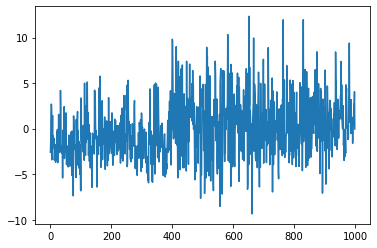

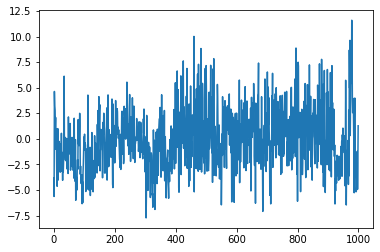

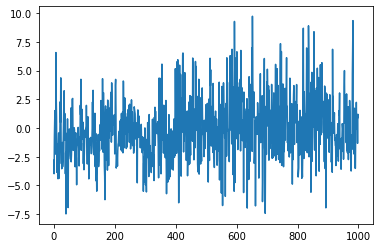

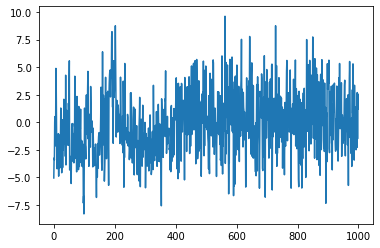

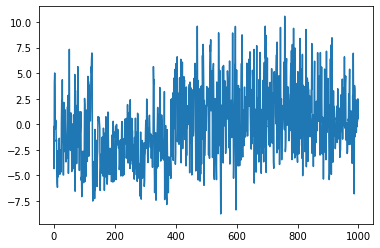

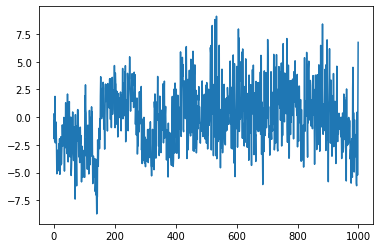

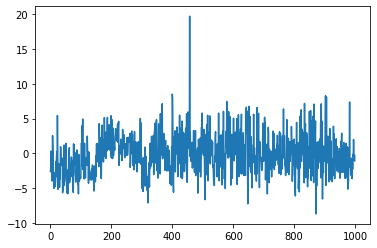

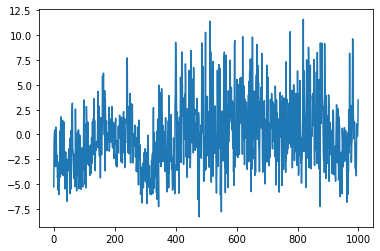

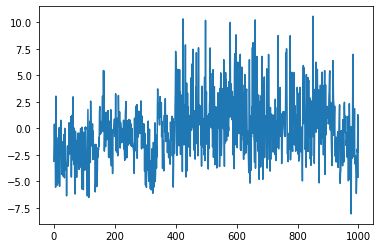

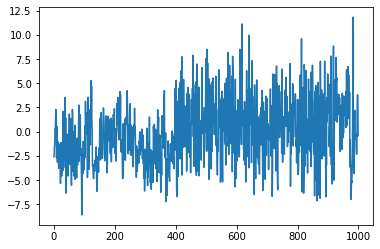

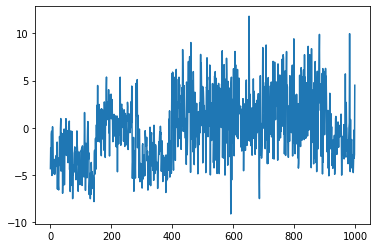

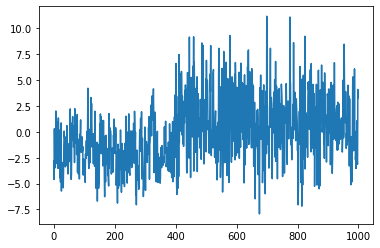

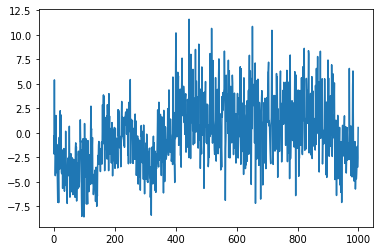

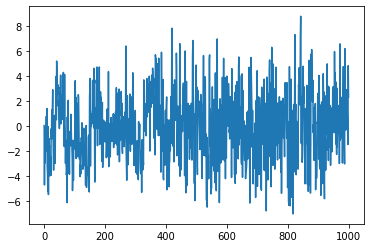

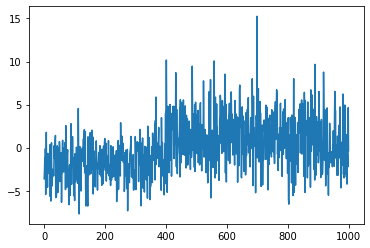

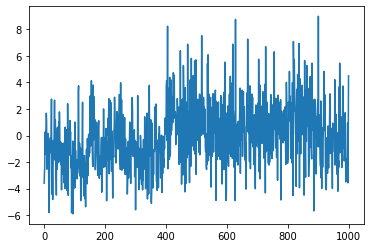

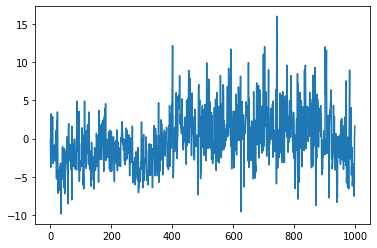

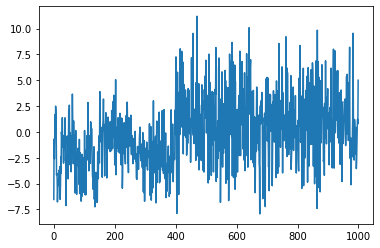

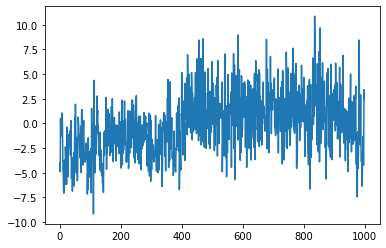

In [15]:
for nn_output in random.sample(neural_net_outputs, 20):
    plt.figure()
    plt.plot(range(1000), nn_output)

### Dimensionality Reduction: t-SNE

This neural net we've got is neat and all, but it's not exactly something we can easily see — after all, it outputs a vector in $\mathbb{R}^{1000}$!

So we can use some dimensionality reduction procedure in order to get some visualization in $\mathbb{R}^2$. In particular, t-SNE provides a projection where points that were close together continue close while points that were far apart remain distant; this is quite desirable in our application.

Scikit-Learn provides a neat API for t-SNE:

In [16]:
tsne = sklearn.manifold.TSNE().fit_transform(neural_net_outputs);

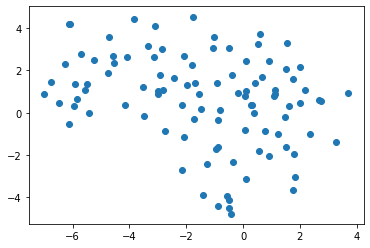

In [17]:
plt.scatter(*tsne.T);

In [43]:
original_images = []
for fpath in os.listdir('/media/daniel/Datasets/ims_julia/medeiros_imgs/'):
    original_images.append(imread(os.path.join('/media/daniel/Datasets/ims_julia/medeiros_imgs/', fpath)))

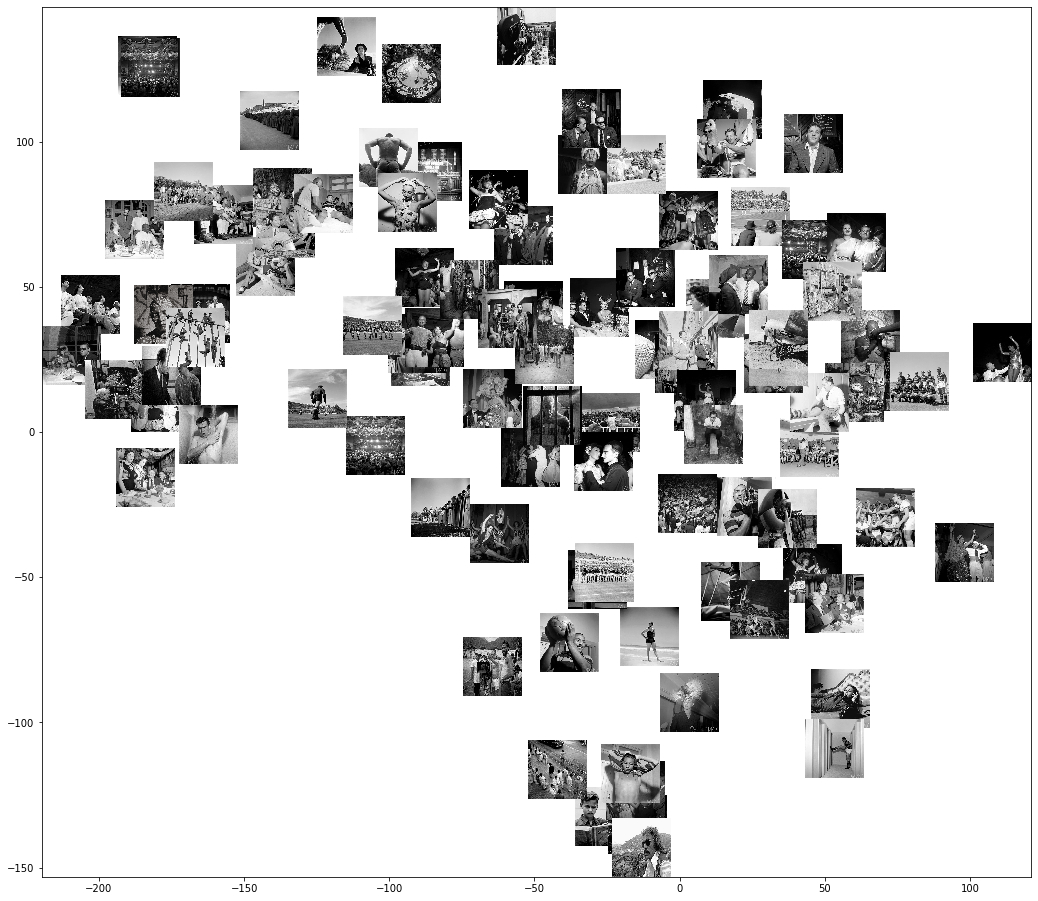

In [45]:
RADIUS = 10
plt.figure(figsize=(18, 16))
for img, pos in zip(original_images, tsne):
    #plt.imshow(imresize(img, (2*RADIUS, 2*RADIUS)), origin=(x,y))
    x,y = 3*RADIUS*pos
    plt.imshow(img, extent=(x-RADIUS, x+RADIUS, y-RADIUS, y+RADIUS), cmap='gray')
plt.scatter(*2*RADIUS*tsne.T, alpha=0)
plt.show()

## Approach #2: VGG-16 Feature Vectors + Cosine Similarity
<a id='approach_n_two'></a>

This is well-explained in [here](https://www.ethanrosenthal.com/2016/12/05/recasketch-keras/).

The last three [fully-connected] layers in VGG-16 are for transforming the features into a classification. Popping these last layers off, we get the features themselves, which we can then calculate similarity vectors using cosine similarity (explained later).

Finally, to visualize the result, we use t-SNE again.

### Preparing the Neural Net

Let's start by loading Keras' VGG-16, pretrained on the ImageNet dataset.

In [3]:
original_model = tf.keras.applications.vgg16.VGG16()
original_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
inp = original_model.input
out = original_model.layers[-4].output
model = tf.keras.Model(inp, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

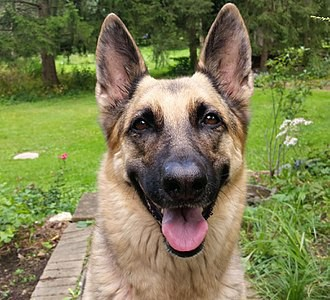

In [9]:
Image(filename="/home/daniel/Desktop/test.jpeg")

In [10]:
preprocessed_image = prepare_image("/home/daniel/Desktop/test.jpeg");

In [11]:
predictions = original_model.predict(preprocessed_image)

array([[8.52483034e-04, 4.39114956e-04, 1.36007078e-03, 3.17735807e-03,
        9.96106025e-03, 2.38629873e-03, 1.63227115e-02, 1.63783843e-04,
        2.18079702e-04, 2.31639846e-04, 1.37329465e-04, 1.12208465e-04,
        4.50899650e-04, 1.09615119e-03, 1.13316426e-04, 9.58706878e-05,
        3.99092823e-04, 3.07193288e-04, 2.15206543e-04, 4.65109799e-04,
        5.03001444e-04, 8.81333021e-04, 2.86727620e-04, 7.11682718e-04,
        1.81124124e-04, 4.05271094e-05, 3.45747074e-04, 1.01317106e-04,
        3.45239496e-05, 4.56603710e-03, 7.51070183e-05, 8.73308891e-05,
        8.32539517e-05, 2.50751409e-03, 2.04283488e-03, 2.14335145e-04,
        5.60118002e-04, 1.11843940e-04, 8.76461563e-04, 2.77115148e-04,
        3.24020599e-04, 1.32489557e-04, 2.17517430e-04, 2.74099992e-04,
        2.18314541e-04, 1.10445870e-03, 2.86259310e-04, 4.11534071e-04,
        1.49943598e-03, 4.63188509e-04, 7.37769878e-04, 1.05821877e-03,
        5.55778446e-04, 4.03813377e-04, 2.73970654e-04, 1.920733

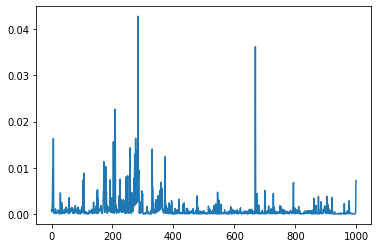

In [12]:
plt.plot(range(predictions.shape[1]), list(predictions[0]));

In [13]:
predictions = model.predict(preprocessed_image)

array([[0.4546583 , 0.        , 0.29893002, ..., 0.        , 0.7166012 ,
        0.        ]], dtype=float32)

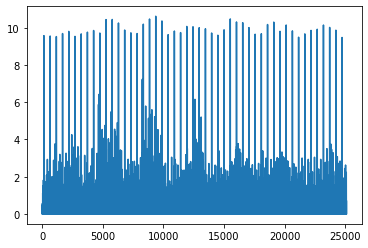

In [15]:
plt.plot(range(predictions.shape[1]), list(predictions[0]));

### Loading the Images

In [19]:
images = load_images("/media/daniel/Datasets/ims_julia/medeiros_imgs/");

### Running the Images Through the Neural Net

In [31]:
neural_net_outputs = list(map(lambda x: np.squeeze(model.predict(x)), images));

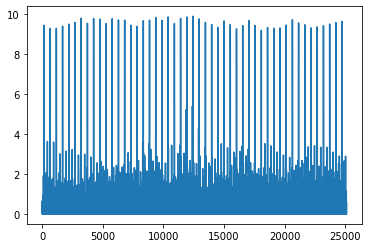

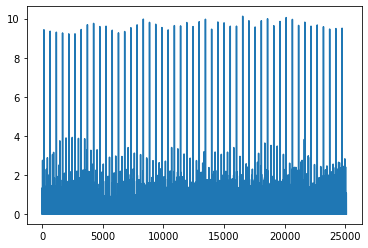

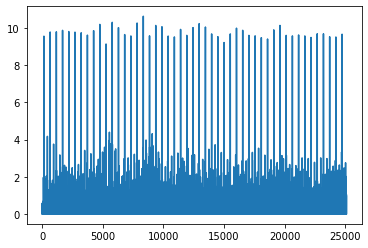

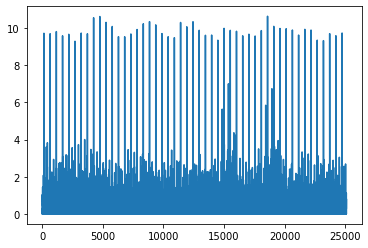

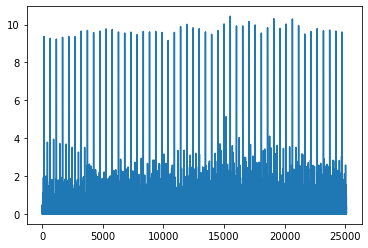

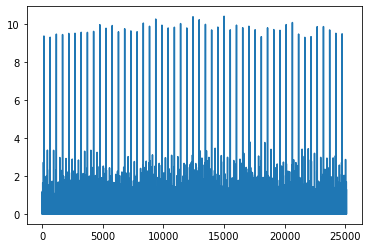

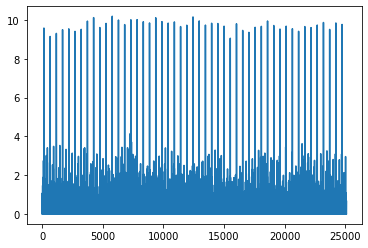

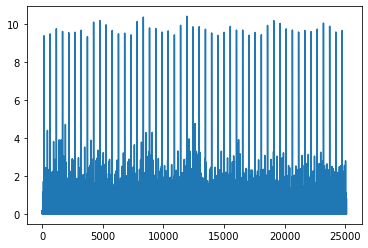

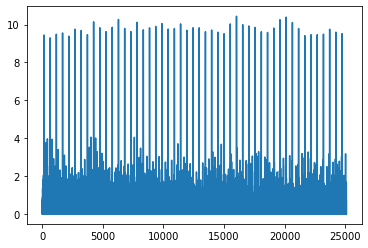

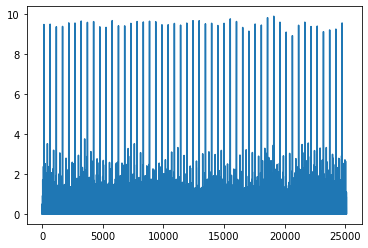

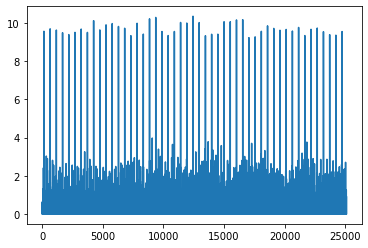

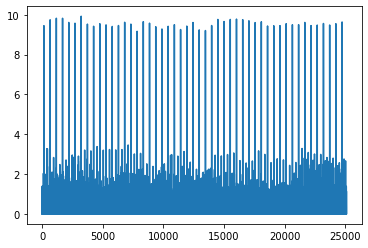

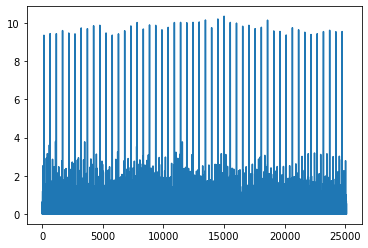

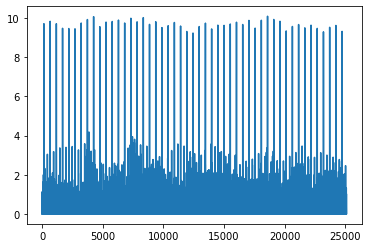

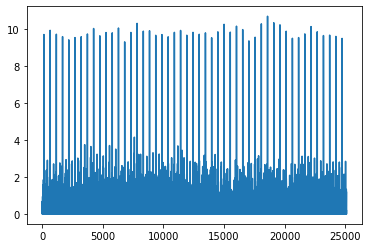

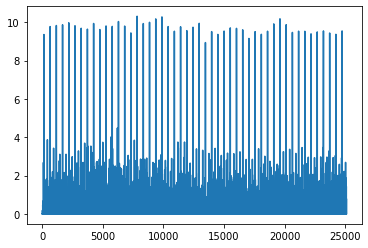

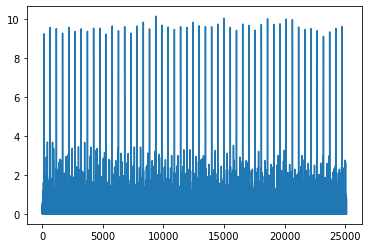

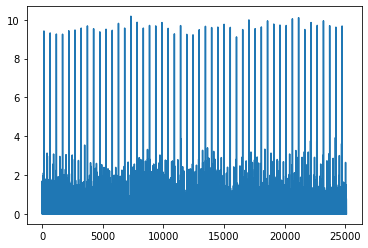

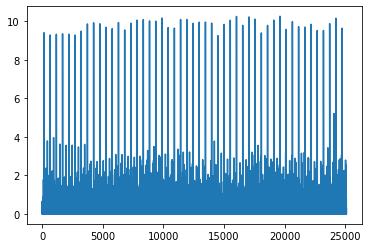

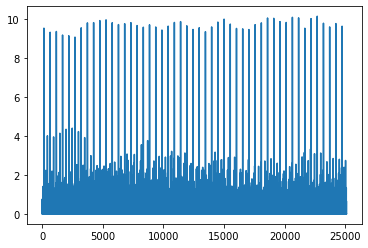

In [95]:
for nn_output in random.sample(neural_net_outputs, 20):
    plt.figure()
    plt.plot(range(25088), nn_output)

### Finding the Similarity Vectors

In [68]:
preds = np.asarray(neural_net_outputs)

array([[0.0000000e+00, 0.0000000e+00, 1.2661052e-01, ..., 3.1067017e-01,
        6.1976200e-01, 0.0000000e+00],
       [7.0192367e-03, 0.0000000e+00, 5.5126160e-01, ..., 8.3974145e-02,
        6.9649518e-01, 0.0000000e+00],
       [6.1857700e-04, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        6.5059602e-01, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0685991e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0968058e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.5249673e-02,
        1.0837616e+00, 0.0000000e+00]], dtype=float32)

In [74]:
similarities_unormalized = preds @ preds.T;

In [76]:
norms = np.array([np.sqrt(np.diagonal(similarities_unormalized))])
similarities = similarities_unormalized / norms / norms.T;

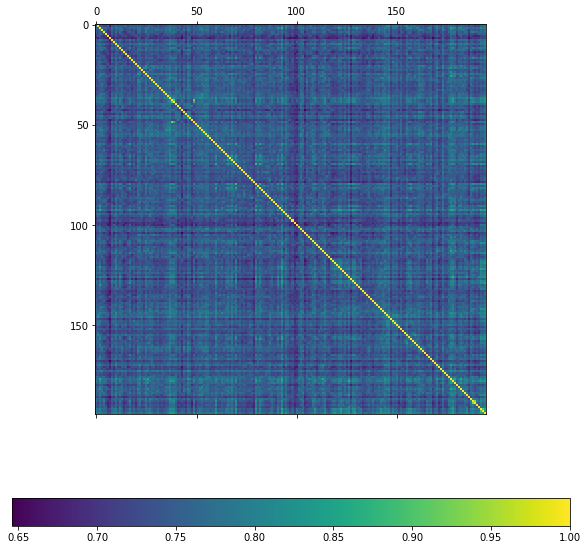

In [100]:
plt.figure(figsize=(10,10))
plt.matshow(similarities, fignum=1)
plt.colorbar(location='bottom')
plt.show();

### Dimensionality Reduction: t-SNE

This neural net we've got is neat and all, but it's not exactly something we can easily see — after all, it outputs a vector in $\mathbb{R}^{1000}$!

So we can use some dimensionality reduction procedure in order to get some visualization in $\mathbb{R}^2$. In particular, t-SNE provides a projection where points that were close together continue close while points that were far apart remain distant; this is quite desirable in our application.

Scikit-Learn provides a neat API for t-SNE:

In [101]:
#tsne = sklearn.manifold.TSNE().fit_transform(neural_net_outputs);
tsne = sklearn.manifold.TSNE().fit_transform(similarities);

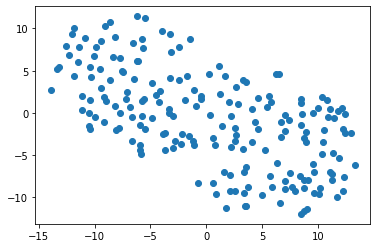

In [102]:
plt.scatter(*tsne.T);

In [107]:
original_images = []
for fpath in os.listdir('/media/daniel/Datasets/ims_julia/medeiros_imgs/'):
    original_images.append(imread(os.path.join('/media/daniel/Datasets/ims_julia/medeiros_imgs/', fpath)))

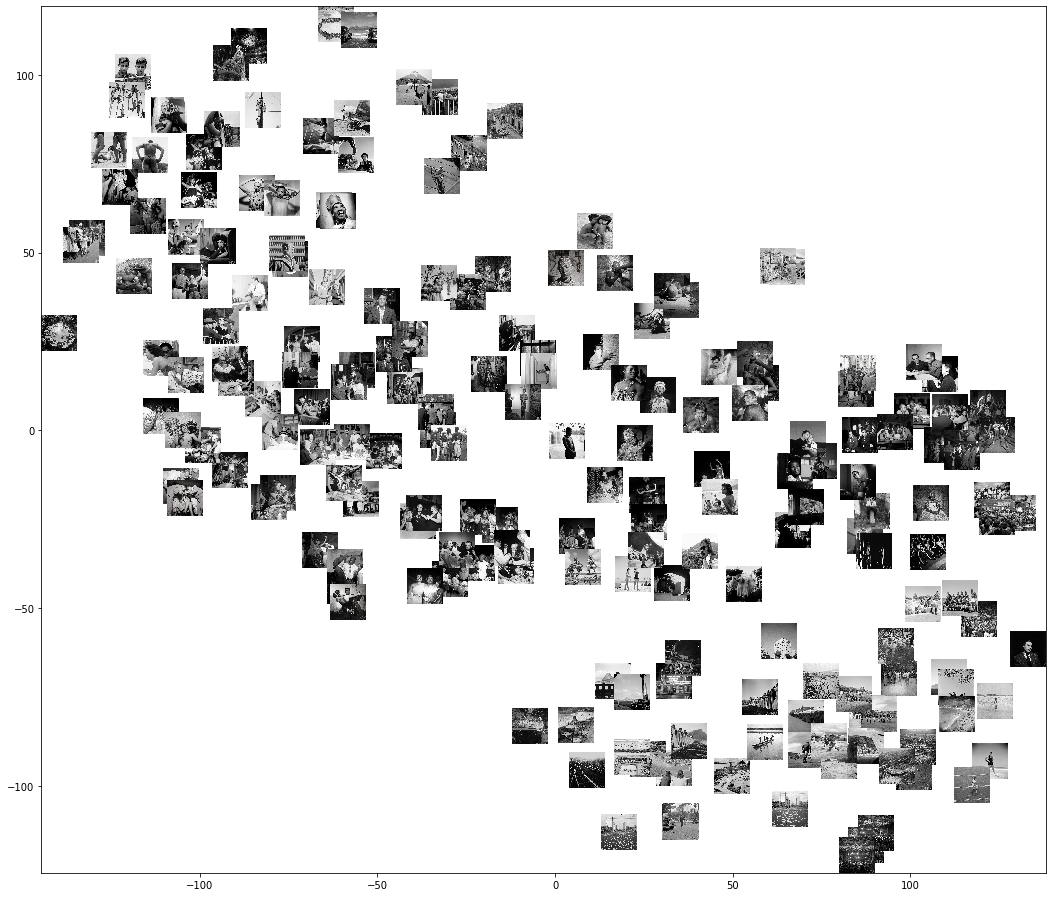

In [106]:
RADIUS = 5
SCALE  = 1
plt.figure(figsize=(18, 16))
for img, pos in zip(original_images, tsne):
    #plt.imshow(imresize(img, (2*RADIUS, 2*RADIUS)), origin=(x,y))
    x,y = 2*RADIUS*pos
    plt.imshow(img, extent=(x-SCALE*RADIUS, x+SCALE*RADIUS, y-SCALE*RADIUS, y+SCALE*RADIUS), cmap='gray')
plt.scatter(*2*RADIUS*tsne.T, alpha=0)
plt.show()

## Approach #3: MobileNet Logits + Cosine Similarity

This is exactly the same as [approach #1](#approach_n_one), except we calculate t-SNE on the similarity vectors, using cosine similarity (as in [approach #2](#approach_n_two)).
The results of a MobileNet are likely weaker than that of a VGG, but it's still worth trying.

### Preparing the Neural Net

Let's start by loading the MobileNet, pre-trained on the ImageNet dataset:

In [3]:
original_model = tf.keras.applications.mobilenet.MobileNet()
original_model.summary()

W1009 17:18:16.401990 140596057966400 deprecation.py:506] From /home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

The last layer is a softmax, which is typical for classification neural nets. However, according to the above mentioned article, we want to use logits instead. So let's change that layer:

In [4]:
inp = original_model.input
out = tf.keras.layers.Activation('linear', name='logits')(original_model.layers[-2].output)
model = tf.keras.Model(inp, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

Let's try the nets out!

[ref](https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299)

In [8]:
def prepare_image(fpath):
    img = tf.keras.preprocessing.image.load_img(fpath, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

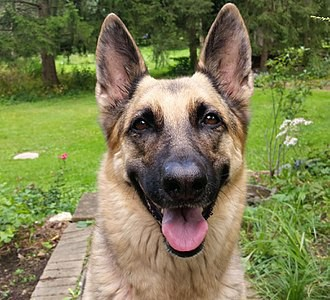

In [6]:
Image(filename="/home/daniel/Desktop/test.jpeg")

In [7]:
preprocessed_image = prepare_image("/home/daniel/Desktop/test.jpeg");

In [8]:
predictions = original_model.predict(preprocessed_image)

array([[1.19461163e-09, 2.84506115e-13, 2.49886414e-11, 4.88193964e-11,
        1.01400301e-12, 2.16586835e-11, 1.63288382e-13, 2.14552291e-12,
        2.95246293e-11, 1.03407148e-12, 8.80158143e-13, 6.58240866e-12,
        1.66328756e-12, 1.61566114e-14, 1.07858512e-13, 3.47058493e-12,
        4.51149014e-12, 1.24923197e-10, 2.46218692e-12, 2.32476234e-12,
        2.68197292e-12, 1.45627416e-11, 9.46774041e-15, 1.61779149e-11,
        2.10289442e-11, 4.51118240e-11, 1.01689325e-11, 5.02934879e-13,
        1.64217754e-11, 3.60708073e-13, 2.33906969e-13, 4.90462824e-15,
        1.23760431e-13, 2.07976802e-10, 3.22387191e-12, 5.18240555e-11,
        1.37026779e-11, 5.73876060e-12, 1.06748464e-12, 3.33736142e-12,
        9.28303333e-13, 9.28834700e-13, 4.01443744e-13, 1.50920400e-12,
        6.75273314e-13, 1.62584113e-10, 2.79064478e-13, 2.50982169e-11,
        3.61054990e-13, 6.44720009e-14, 7.66513724e-14, 5.98883221e-10,
        1.81784969e-11, 1.93016974e-11, 4.68875876e-11, 1.373750

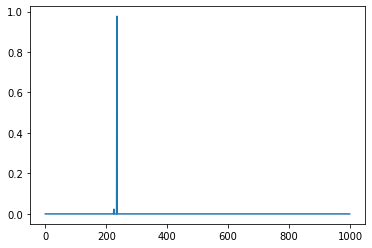

In [9]:
plt.plot(range(predictions.shape[1]), list(predictions[0]));

In [10]:
predictions = model.predict(preprocessed_image)

array([[ 3.74853802e+00, -4.59403944e+00, -1.18618369e-01,
         5.51087976e-01, -3.32313395e+00, -2.61633158e-01,
        -5.14927721e+00, -2.57365656e+00,  4.81849909e-02,
        -3.30353546e+00, -3.46469307e+00, -1.45263791e+00,
        -2.82824397e+00, -7.46246433e+00, -5.56397390e+00,
        -2.09271693e+00, -1.83041191e+00,  1.49065888e+00,
        -2.43598914e+00, -2.49342251e+00, -2.35048723e+00,
        -6.58572614e-01, -7.99690533e+00, -5.53393126e-01,
        -2.91139573e-01,  4.72105533e-01, -1.01770258e+00,
        -4.02433443e+00, -5.38430333e-01, -4.35672665e+00,
        -4.78987074e+00, -8.65461445e+00, -5.42644644e+00,
         2.00038624e+00, -2.16645575e+00,  6.10815108e-01,
        -7.19448388e-01, -1.58979511e+00, -3.27173448e+00,
        -2.13185954e+00, -3.41143656e+00, -3.41086411e+00,
        -4.24972677e+00, -2.92545748e+00, -3.72967720e+00,
         1.75415564e+00, -4.61335278e+00, -1.14242733e-01,
        -4.35576344e+00, -6.07856369e+00, -5.90552807e+0

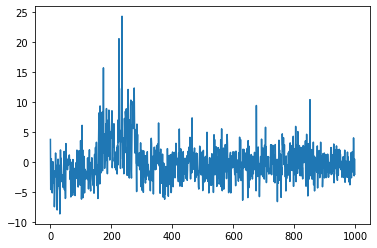

In [11]:
plt.plot(range(predictions.shape[1]), list(predictions[0]));

### Loading the Images

We reuse the function `prepare_image` (defined in the previous section) in order to load a bunch of images in a given directory.

In [17]:
def load_images(directory):
    output = []
    for fname in os.listdir(directory):
        output.append(prepare_image(os.path.join(directory, fname)))
    return output

In [13]:
images = load_images("/media/daniel/Datasets/ims_julia/medeiros_imgs/");

### Running the Images Through the Neural Net

In [14]:
neural_net_outputs = list(map(lambda x: np.squeeze(model.predict(x)), random.sample(images, 100)));

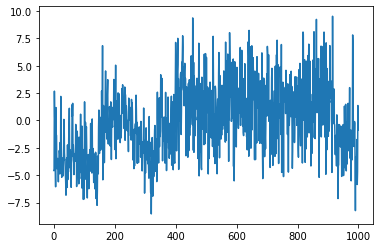

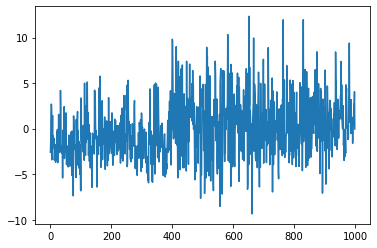

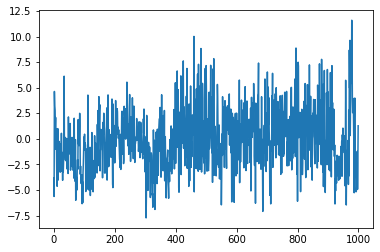

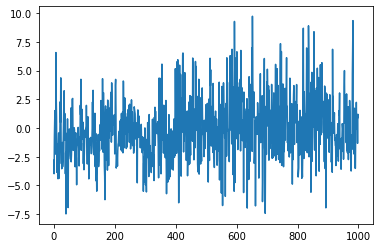

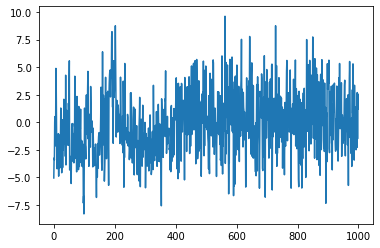

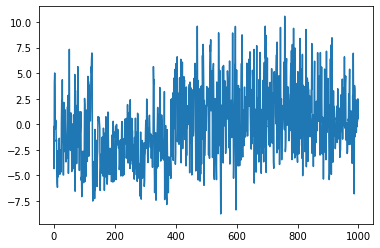

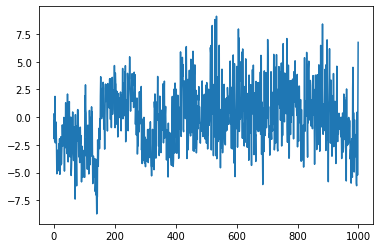

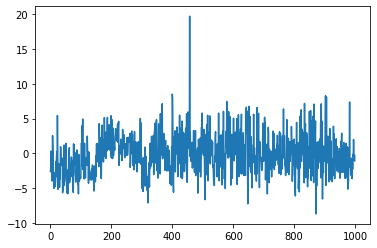

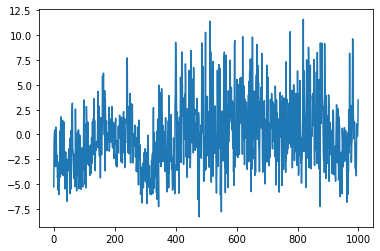

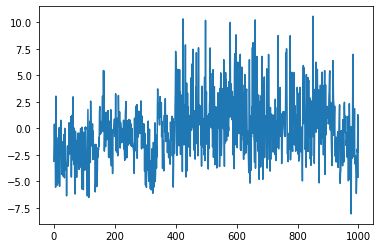

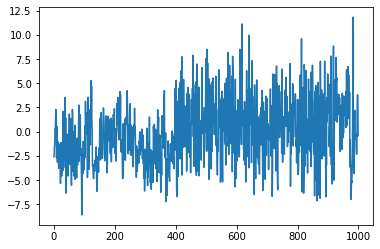

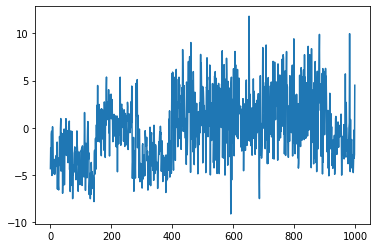

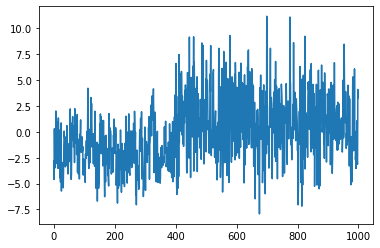

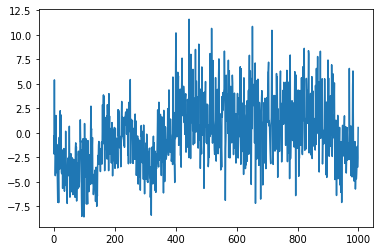

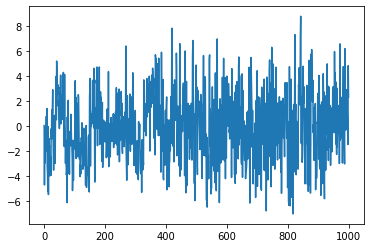

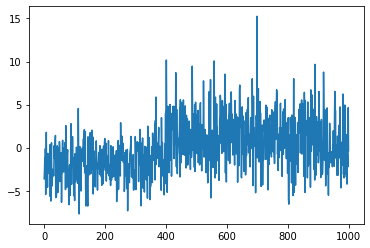

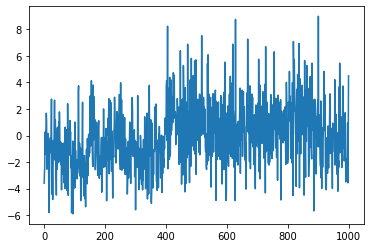

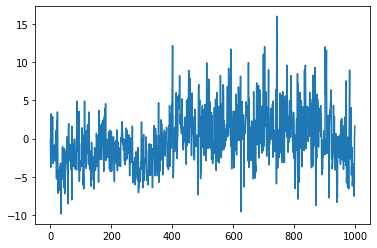

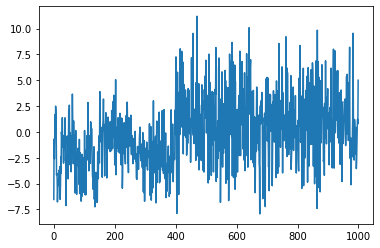

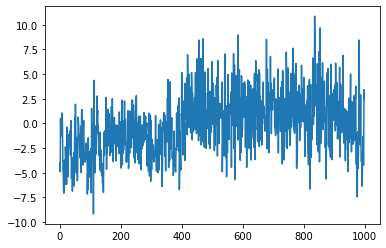

In [15]:
for nn_output in random.sample(neural_net_outputs, 20):
    plt.figure()
    plt.plot(range(1000), nn_output)

### Finding the Similarity Vectors

In [68]:
preds = np.asarray(neural_net_outputs)

array([[0.0000000e+00, 0.0000000e+00, 1.2661052e-01, ..., 3.1067017e-01,
        6.1976200e-01, 0.0000000e+00],
       [7.0192367e-03, 0.0000000e+00, 5.5126160e-01, ..., 8.3974145e-02,
        6.9649518e-01, 0.0000000e+00],
       [6.1857700e-04, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        6.5059602e-01, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0685991e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0968058e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.5249673e-02,
        1.0837616e+00, 0.0000000e+00]], dtype=float32)

In [74]:
similarities_unormalized = preds @ preds.T;

In [76]:
norms = np.array([np.sqrt(np.diagonal(similarities_unormalized))])
similarities = similarities_unormalized / norms / norms.T;

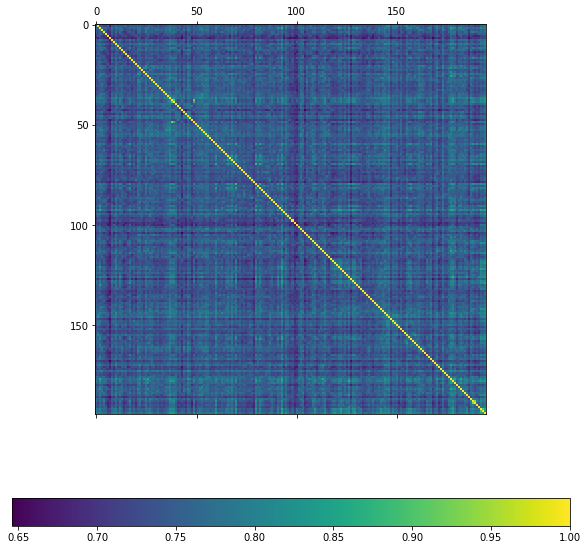

In [100]:
plt.figure(figsize=(10,10))
plt.matshow(similarities, fignum=1)
plt.colorbar(location='bottom')
plt.show();

### Dimensionality Reduction: t-SNE

This neural net we've got is neat and all, but it's not exactly something we can easily see — after all, it outputs a vector in $\mathbb{R}^{1000}$!

So we can use some dimensionality reduction procedure in order to get some visualization in $\mathbb{R}^2$. In particular, t-SNE provides a projection where points that were close together continue close while points that were far apart remain distant; this is quite desirable in our application.

Scikit-Learn provides a neat API for t-SNE:

In [16]:
tsne = sklearn.manifold.TSNE().fit_transform(similarities);

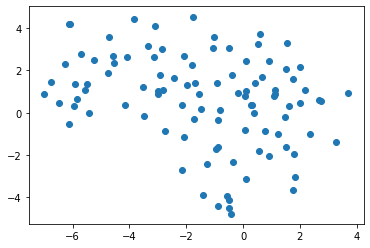

In [17]:
plt.scatter(*tsne.T);

In [43]:
original_images = []
for fpath in os.listdir('/media/daniel/Datasets/ims_julia/medeiros_imgs/'):
    original_images.append(imread(os.path.join('/media/daniel/Datasets/ims_julia/medeiros_imgs/', fpath)))

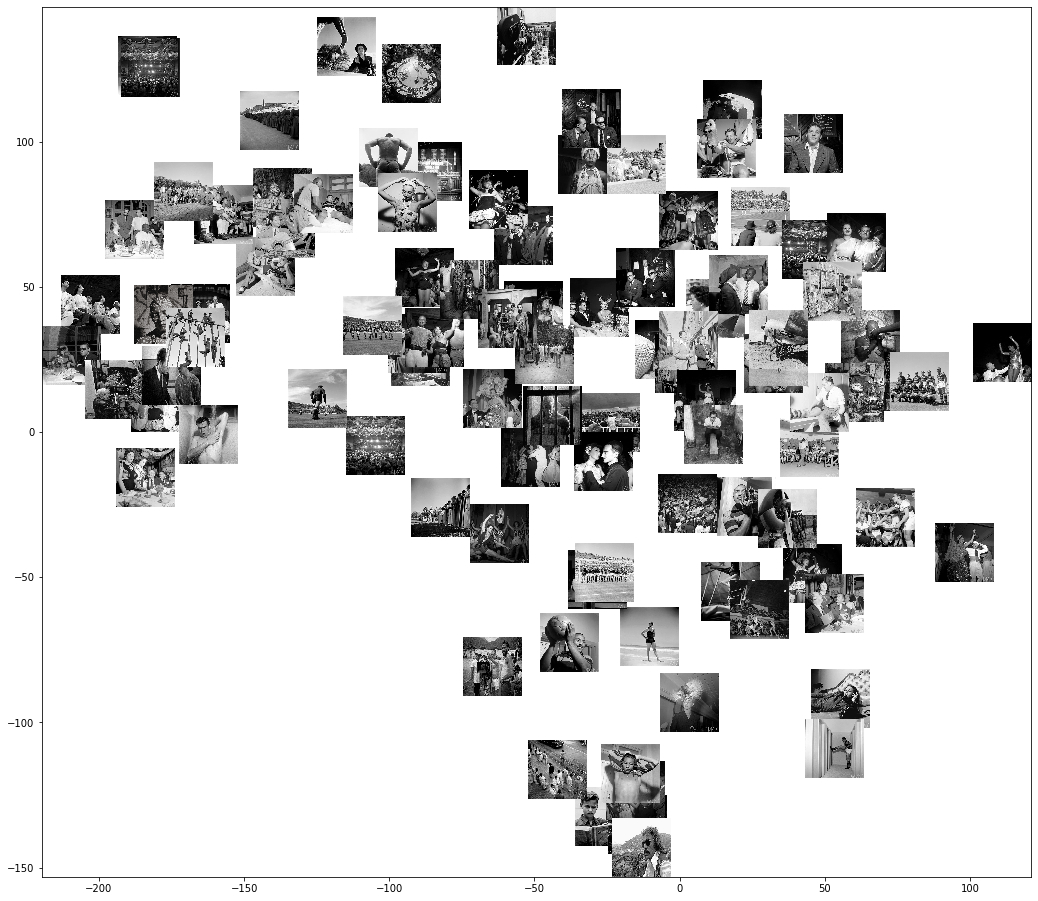

In [45]:
RADIUS = 10
plt.figure(figsize=(18, 16))
for img, pos in zip(original_images, tsne):
    #plt.imshow(imresize(img, (2*RADIUS, 2*RADIUS)), origin=(x,y))
    x,y = 3*RADIUS*pos
    plt.imshow(img, extent=(x-RADIUS, x+RADIUS, y-RADIUS, y+RADIUS), cmap='gray')
plt.scatter(*2*RADIUS*tsne.T, alpha=0)
plt.show()